In [1]:
import normflows as nf
from normflows import flows
## Standard libraries
import os
import math
import time
import numpy as np 
import numpy.ma as ma

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset

import umap
reducer = umap.UMAP();
from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/v

Using device cuda:0


In [2]:
#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info
from models import GIN, HeteroGIN
from NF_utils import Latent_data, create_latent_data, get_masked_affine, transform, train,plot_loss, test,plot_9_histos, plot_UMAP_sidebyside,plot_UMAP_overlay

Using device cuda:0


In [3]:
import random

In [4]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''

# Data and MC both have the same prefix
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"

# MC inside Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
MCdataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

# Data inside data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
DATAdataset = "data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

max_events = 1e5
split = 0.1
nlayers = 2
nmlp = 3
hdim = 64
nclasses, nfeatures, nfeatures_edge = get_graph_dataset_info(dataset=MCdataset, prefix=prefix)
dropout = 0.8
learn_eps = False
batch = 256
indices = None
nworkers = 0
npooling = "max"
gpooling = "max"
torch.manual_seed(0)

#select model
extractor = GIN(nlayers, nmlp, nfeatures,
            hdim, nclasses, dropout, learn_eps, npooling, gpooling).to(device)
extractor.load_state_dict(torch.load("logs/model_weights",map_location=device))
#select training data

<All keys matched successfully>

In [5]:
training_data_DATA = create_latent_data(DATAdataset, extractor)
training_data_MC = create_latent_data(MCdataset, extractor)

testing_data_DATA = create_latent_data(DATAdataset, extractor, mode = "test")
testing_data_MC = create_latent_data(MCdataset, extractor, mode = "test")

No mode given, defaulting to training



/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


No mode given, defaulting to training



#### Look at lines 1164 in utils.py for which distributions to use for color coded UMAP

In [27]:
loc = np.ones(71)
loc += 1

In [28]:
#multi modal Gaussians
maf_MC_7G = get_masked_affine()
G7_MC = nf.distributions.GaussianMixture(2,training_data_MC.latent_size, loc = loc,trainable = False)
NF_G7_MC_model = nf.NormalizingFlow(q0=G7_MC, flows=maf_MC_7G)
NF_G7_MC_model = NF_G7_MC_model.to(device)

maf_DATA_7G = get_masked_affine()
G7_DATA = nf.distributions.GaussianMixture(2,training_data_DATA.latent_size, loc = loc, trainable = False)
NF_G7_DATA_model = nf.NormalizingFlow(q0=G7_DATA, flows=maf_DATA_7G)
NF_G7_DATA_model = NF_G7_DATA_model.to(device)

  0%|          | 0/448 [00:36<?, ?it/s]


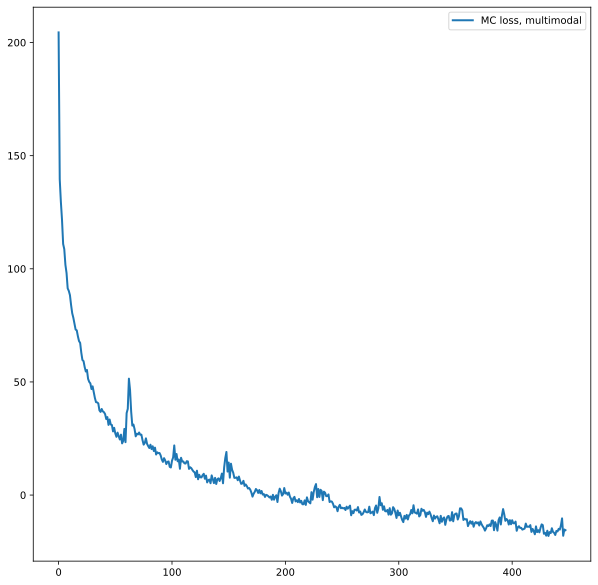

Lowest Loss: -18.08392906188965


In [29]:
# TRAINING MC w/multimodal gauss
loss_hist = train(training_data_MC, NF_G7_MC_model)
plot_loss(loss_hist, label = "MC loss, multimodal")

  0%|          | 0/448 [00:35<?, ?it/s]


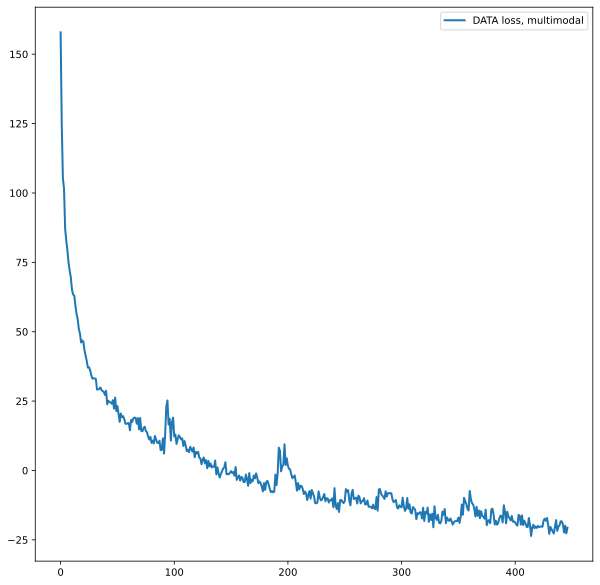

Lowest Loss: -23.59669303894043


In [30]:
# TRAINING DATA w/multimodal gauss
loss_hist = train(training_data_DATA, NF_G7_DATA_model)
plot_loss(loss_hist, label = "DATA loss, multimodal")

In [31]:
# Testing MC
test(testing_data_MC, NF_G7_MC_model, data_type = "MC")
# Testing DATA
test(testing_data_DATA, NF_G7_DATA_model, data_type = "DATA")

100%|██████████| 112/112 [00:01<00:00, 56.44it/s]


MC average loss: -16.110389709472656


100%|██████████| 112/112 [00:01<00:00, 56.36it/s]

DATA average loss: -21.302143096923828


In [32]:
#Transforming with new multimodal Gauss
transformed_MC_G7 = transform(testing_data_MC, NF_G7_MC_model)
transformed_DATA_G7 = transform(testing_data_DATA, NF_G7_DATA_model)

100%|██████████| 112/112 [00:02<00:00, 52.31it/s]


## UMAP Projection of latent MC color coded, multimodal Gaussian

In [ ]:
reducer_cc = umap.UMAP(random_state=42)
embedding_cc = reducer_cc.fit_transform(transformed_MC_G7)

In [12]:
MC_dataset = GraphDataset(prefix+MCdataset)
MC_dataset.load()
MC_dataset.shuffle()
MC_dataset = Subset(MC_dataset,range(112000,140000))

In [13]:
label_tensor = testing_data_MC.labels

In [14]:
num_signal = label_tensor.sum()

In [15]:
MC_embedded_signal = np.zeros((int(num_signal), 2))
MC_embedded_bg = np.zeros(((140000 - 112000)-int(num_signal), 2))
bg_count, signal_count = 0, 0
for i in range(140000 - 112000):
    if label_tensor[i]:
        MC_embedded_signal[signal_count] = embedding_cc[i]
        signal_count+= 1
    else:
        MC_embedded_bg[bg_count] = embedding_cc[i]
        bg_count += 1

In [16]:
plot_UMAP_overlay(MC_embedded_signal,MC_embedded_bg,"b",
                     'r',description = "Latent", 
                     left_description = "signal", right_description = "background", save = True, save_loc = "plots/G4_sig_vs_bg.jpeg")

#### Multimodal histograms

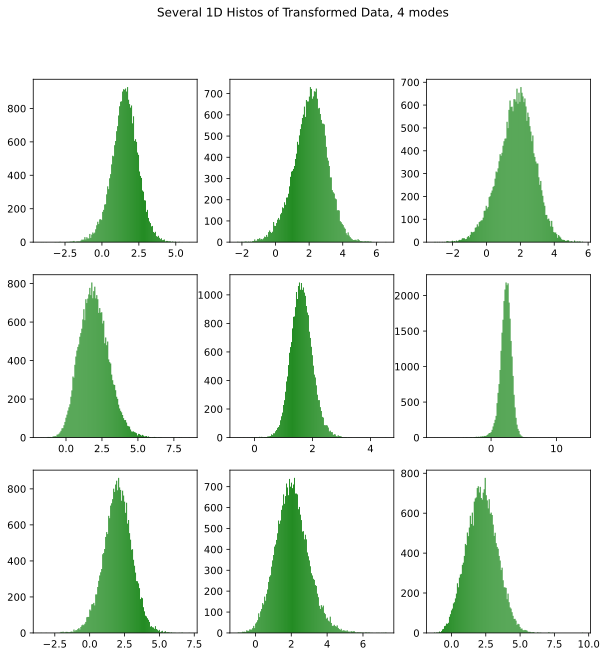

In [33]:
plot_9_histos(transformed_DATA_G7, "forestgreen", description = "of Transformed Data, 4 modes" )

## UMAP projection of normalized MC and DATA via MC fit

In [ ]:
reducer_n_MC = umap.UMAP(random_state=42)
reducer_n_MC.fit(transformed_latent_MC)
embedding_MC_transformed_MCf = reducer_n_MC.transform(transformed_latent_MC)
embedding_DATA_transformed_MCf = reducer_n_MC.transform(transformed_latent_DATA)

In [ ]:
#Plotting both transformed Spaces using subplots
plot_UMAP_sidebyside(embedding_MC_transformed_MCf,embedding_DATA_transformed_MCf,"forestgreen",
                     "tab:purple",description = "Transformed via MC fit", 
                     left_description = "MC", right_description = "DATA")

## UMAP projection of normalized MC and DATA via DATA fit

In [ ]:
reducer_n_DATA = umap.UMAP(random_state=42)

In [ ]:
reducer_n_DATA.fit(transformed_latent_DATA)
embedding_MC_transformed_DATAf = reducer_n_DATA.transform(transformed_latent_MC)
embedding_DATA_transformed_DATAf = reducer_n_DATA.transform(transformed_latent_DATA)

In [ ]:
#Plotting both transformed Spaces using subplots
plot_UMAP_sidebyside(embedding_MC_transformed_DATAf,embedding_DATA_transformed_DATAf,"forestgreen",
                     "tab:purple",description = "Transformed via DATA fit", 
                     left_description = "MC", right_description = "DATA")

## UMAP projection of latent MC and DATA via MC fit

In [ ]:
reducer_l_MCf = umap.UMAP(random_state=42)

In [ ]:
reducer_l_MCf.fit(training_data_MC.data)
embedding_MC_latent_MCf = reducer_l_MCf.transform(training_data_MC.data)
embedding_DATA_latent_MCf = reducer_l_MCf.transform(training_data_DATA.data)

In [ ]:
#Plotting both transformed Spaces using subplots
plot_UMAP_sidebyside(embedding_MC_latent_MCf,embedding_DATA_latent_MCf,"b",
                     "r",description = "original latent via MC fit", 
                     left_description = "MC", right_description = "DATA", save = True, save_loc = "plots/UMAP_sbs_original_latent_MCf.jpeg")

In [ ]:
plot_UMAP_overlay(embedding_MC_latent_MCf,embedding_DATA_latent_MCf,"b",
                     'r',description = "Original latent via MC fit", 
                     left_description = "MC", right_description = "DATA", save = True, save_loc = "plots/UMAP_overlay_original_latent_MCf.jpeg")

#### Plotting FullPass Data

In [ ]:
intermediate_data_obj = Latent_data(transformed_latent_DATA,testing_data_DATA.labels)
intermediate_data_obj.set_batch_size(250)

In [ ]:
full_pass_DATA = transform(intermediate_data_obj, MC_model, reverse = False)

In [ ]:
reducer_l_test_MCf = umap.UMAP(random_state=42)
reducer_l_test_MCf.fit(testing_data_MC.data)
embedding_test_MC_latent_MCf = reducer_l_test_MCf.transform(testing_data_MC.data)
embedding_test_fullpass_MCf = reducer_l_test_MCf.transform(testing_data_DATA.data)

In [ ]:
#plotting full pass DATA
plot_UMAP_sidebyside(embedding_test_MC_latent_MCf,embedding_test_fullpass_MCf,"b",
                     "r",description = "Original latent via MC fit", 
                     left_description = "MC", right_description = "DATA fullpass", save = True, save_loc = "plots/UMAP_sbs_fullpass.jpeg")